<a href="https://colab.research.google.com/github/basselsuccar/CSC-4444-Project/blob/main/ClassifyingEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPool2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip>/dev/null
!rm -rf train/disgust train/fear train/angry train/surprise test/disgust test/fear test/angry test/surprise

Saving kaggle.json to kaggle.json
 81% 49.0M/60.3M [00:00<00:00, 72.7MB/s]
100% 60.3M/60.3M [00:00<00:00, 72.4MB/s]


In [3]:
image_size=(48,48)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    batch_size=64,
    image_size=image_size,
    shuffle=True,
    color_mode="grayscale",
    validation_split=0.2,
    subset="training",
    seed = 123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    batch_size=64,
    image_size=image_size,
    shuffle=True,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    seed = 123
)
test_dataset=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=64,image_size=image_size,
                                                            shuffle=False,color_mode="grayscale")

Found 17010 files belonging to 3 classes.
Using 13608 files for training.
Found 17010 files belonging to 3 classes.
Using 3402 files for validation.
Found 4254 files belonging to 3 classes.


In [4]:
train_dataset.class_names

['happy', 'neutral', 'sad']

In [5]:
iterator=iter(train_dataset)
(imgs,labels)=iterator.next()
print(imgs.shape,labels.shape)

(64, 48, 48, 1) (64,)


plotting a batch of the training dataset for visualization purposes

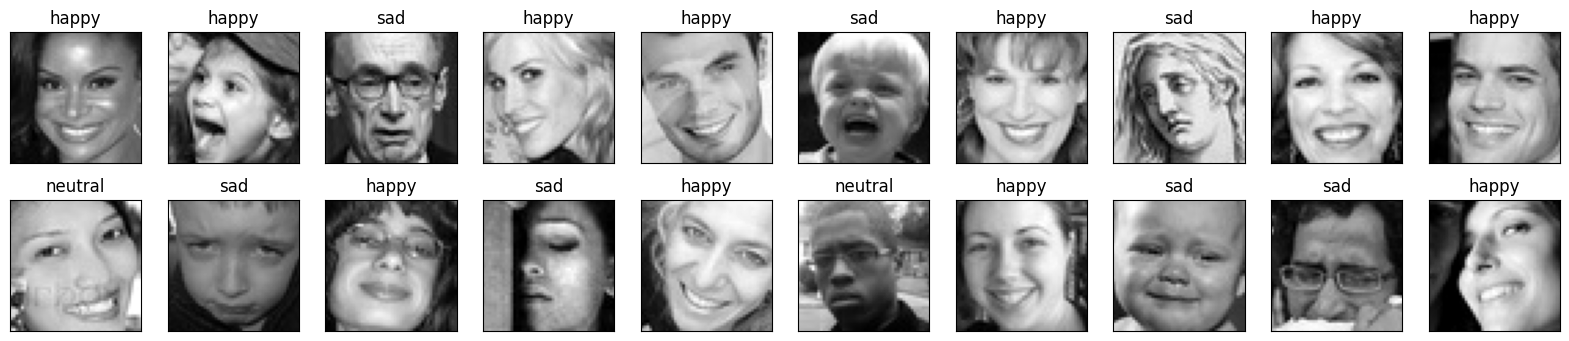

In [6]:
fig=plt.figure(figsize=(20,4))

for i in range(20):

            t=fig.add_subplot(2,10,i+1)
            # set the title of the image equal to its label
            t.set_title(str(train_dataset.class_names[labels[i].numpy()]))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(np.squeeze(imgs[i]),cmap='gray')

In [7]:
def get_model():
    model = Sequential()
    model.add(Input(shape=(image_size[0],image_size[1],1)))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax', name = 'Output'))
    model.summary()
    return model

In [8]:
model=get_model()
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                        

In [9]:
model.fit(train_dataset,validation_data=validation_dataset,epochs=20)

Epoch 1/20
213/213 [==============================] - 16s 39ms/step - loss: 1.0653 - accuracy: 0.4405 - val_loss: 0.9852 - val_accuracy: 0.5247
Epoch 2/20
213/213 [==============================] - 7s 34ms/step - loss: 0.9379 - accuracy: 0.5507 - val_loss: 0.8470 - val_accuracy: 0.5932
Epoch 3/20
213/213 [==============================] - 8s 36ms/step - loss: 0.8619 - accuracy: 0.5920 - val_loss: 0.7991 - val_accuracy: 0.6226
Epoch 4/20
213/213 [==============================] - 7s 32ms/step - loss: 0.8076 - accuracy: 0.6186 - val_loss: 0.7630 - val_accuracy: 0.6493
Epoch 5/20
213/213 [==============================] - 7s 35ms/step - loss: 0.7633 - accuracy: 0.6411 - val_loss: 0.7282 - val_accuracy: 0.6725
Epoch 6/20
213/213 [==============================] - 7s 33ms/step - loss: 0.7345 - accuracy: 0.6628 - val_loss: 0.7056 - val_accuracy: 0.6884
Epoch 7/20
213/213 [==============================] - 8s 37ms/step - loss: 0.7142 - accuracy: 0.6738 - val_loss: 0.6875 - val_accuracy: 0.694

In [10]:
model.evaluate(test_dataset)

67/67 [==============================] - 2s 22ms/step - loss: 0.6198 - accuracy: 0.7273


[0.6197643280029297, 0.7273154854774475]

now lets classify the user's emotion, lets start by importing the CV2 Haar classifier that will help us detecting the face in the image to crop the image around the face and ignore the background.


In [11]:
import cv2

!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2024-04-19 02:04:24--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2024-04-19 02:04:25 (26.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



Capturing user image for classification, if CV2 Haar classifier couldn't detect a face the code below will throw an error, if that happens just rerun the cell and make sure that your face is centered and not very far from the camera. if CV2 detects the face successfully you can see the plotted cropped image that will be passed to the model in the code cell right after this one.

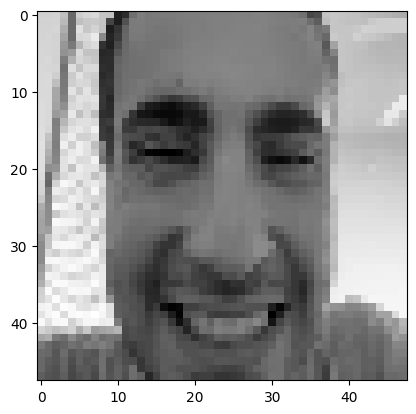

In [39]:
import numpy as np
from PIL import Image
import io
from base64 import b64decode
from IPython.display import HTML
from google.colab.output import eval_js

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))


img=take_photo(size=(256,256))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bboxes = classifier.detectMultiScale(img_gray)
bboxes = np.squeeze(bboxes)

x, y, width, height = bboxes
face = img_gray[y:y+height, x:x+width]
face = cv2.resize(face, (48, 48))

plt.imshow(face, cmap="gray")
plt.show()


Predicting the emotion

In [40]:

r=np.expand_dims(face,0)
r=np.expand_dims(r,3)
res=model.predict(r)
print(test_dataset.class_names[np.argmax(res)])
print(res)

1/1 [==============================] - 0s 32ms/step
happy
[[0.9187219  0.03037476 0.05090337]]
